In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
class AIRS:
    def __init__(self, num_antibodies=50, affinity_threshold=0.5, mutation_rate=0.03, max_epochs=1):
        self.num_antibodies = num_antibodies
        self.affinity_threshold = affinity_threshold
        self.mutation_rate = mutation_rate
        self.max_epochs = max_epochs
        self.antibodies = None
        self.labels = None

    def initialize_antibodies(self, num_features):
        self.antibodies = np.random.rand(self.num_antibodies, num_features)
        self.labels = np.random.randint(2, size=self.num_antibodies)

    def calculate_affinity(self, sample):
        return np.sum(self.antibodies == sample, axis=1) / len(sample)

    def select_antibody(self, sample):
        affinities = self.calculate_affinity(sample)
        max_affinity_idx = np.argmax(affinities)
        if affinities[max_affinity_idx] >= self.affinity_threshold:
            return self.labels[max_affinity_idx]
        else:
            return None

    def mutate_antibodies(self):
        num_mutations = int(self.mutation_rate * self.antibodies.size)
        mutation_indices = np.random.choice(self.antibodies.size, num_mutations, replace=False)
        self.antibodies.flat[mutation_indices] = np.random.rand(num_mutations)

    def fit(self, X, y):
        self.initialize_antibodies(X.shape[1])
        for epoch in range(self.max_epochs):
            for sample, label in zip(X, y):
                predicted_label = self.select_antibody(sample)
                if predicted_label is None:
                    self.antibodies = np.vstack((self.antibodies, sample))
                    self.labels = np.append(self.labels, label)
            self.mutate_antibodies()

    def predict(self, X):
        y_pred = []
        for sample in X:
            predicted_label = self.select_antibody(sample)
            if predicted_label is not None:
                y_pred.append(predicted_label)
            else:
                y_pred.append(np.random.randint(2))  # Random guess if no antibody matches
        return np.array(y_pred)

In [11]:
# Load the dataset
data = pd.read_csv("train.csv")

# Drop irrelevant or redundant columns
data.drop(columns=['area_assesed', 'building_id', 'district_id', 
                   'has_geotechnical_risk', 'has_geotechnical_risk_fault_crack',
                   'has_geotechnical_risk_flood', 'has_geotechnical_risk_land_settlement',
                   'has_geotechnical_risk_landslide', 'has_geotechnical_risk_liquefaction'], inplace=True)

# Replace damage grade with binary label (damage or not damage)
data['damage'] = data['damage_grade'].apply(lambda x: 1 if x > 'Grade 3' else 0)
data.drop(columns=['damage_grade'], inplace=True)

# Split features and labels
X = data.drop(columns=['damage']).values
y = data['damage'].values

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [12]:
# Initialize and train the AIRS model
airs = AIRS()
airs.fit(X_train, y_train)

In [13]:
# Predict
y_pred_train = airs.predict(X_train)
y_pred_test = airs.predict(X_test)

Training Accuracy: 0.5752085443839433
Testing Accuracy: 0.5754038289553869


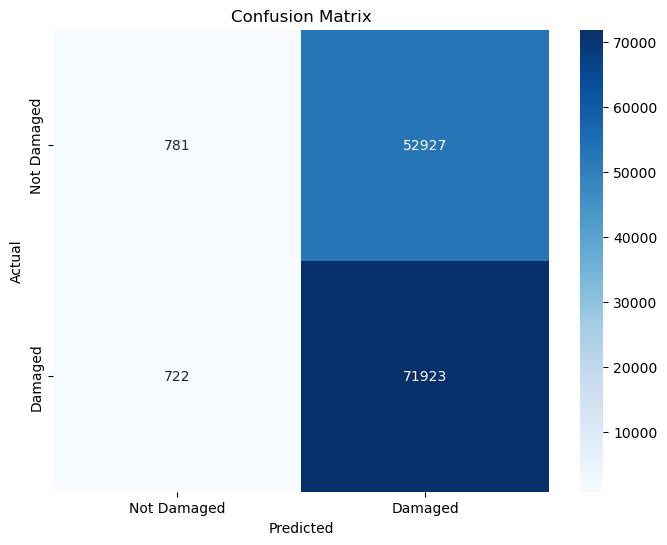

In [14]:
# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"Training Accuracy: {train_accuracy}")
print(f"Testing Accuracy: {test_accuracy}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=['Not Damaged', 'Damaged'], yticklabels=['Not Damaged', 'Damaged'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
